In [383]:
import os
from pprint import pprint

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

import random
import string

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
import optuna

import torch
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetClassifier
from saint import SaintClassifier

from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from eli5.sklearn import PermutationImportance

import shap

ImportError: cannot import name 'SaintClassifier' from 'saint' (/home/elicer/.local/lib/python3.10/site-packages/saint/__init__.py)

In [384]:
!pip install SaintClassifier

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement SaintClassifier (from versions: none)
ERROR: No matching distribution found for SaintClassifier


In [335]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [336]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [337]:
# divide
dam = train.filter(regex='_Dam')
fill1 = train.filter(regex='_Fill1')
fill2 = train.filter(regex='_Fill2')
autoclave = train.filter(regex='_AutoClave')
target = train['target']

# dam
dam = dam.dropna(axis=1, how='all')
dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
dam = dam.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1 = fill1.dropna(axis=1, how='all')
fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2 = fill2.dropna(axis=1, how='all')
fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

# CONCAT
train = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)

# divide
dam_test = test.filter(regex='_Dam')
fill1_test = test.filter(regex='_Fill1')
fill2_test = test.filter(regex='_Fill2')
autoclave_test = test.filter(regex='_AutoClave')

# dam
dam_test = dam_test.dropna(axis=1, how='all')
dam_test = dam_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
dam_mask_test = dam_test[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
dam_test.loc[dam_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam_test.columns[24:]] = dam_mask_test
dam_test = dam_test.drop(columns='WorkMode Collect Result_Dam')

# fill1
fill1_test = fill1_test.dropna(axis=1, how='all')
fill1_test = fill1_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
fill1_mask_test = fill1_test[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
fill1_test.loc[fill1_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1_test.columns[14:]] = fill1_mask_test
fill1_test = fill1_test.drop(columns='WorkMode Collect Result_Fill1')

# fill2
fill2_test = fill2_test.dropna(axis=1, how='all')
fill2_test = fill2_test.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
fill2_mask_test = fill2_test[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
fill2_test.loc[fill2_test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2_test.columns[24:]] = fill2_mask_test
fill2_test = fill2_test.drop(columns='WorkMode Collect Result_Fill2')

# CONCAT
test = pd.concat([dam_test, fill1_test, fill2_test, autoclave_test], axis=1)

/tmp/ipykernel_58/3265365813.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_58/3265365813.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_58/3265365813.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [338]:
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df


# 조건을 만족하는 행 인덱스를 찾음
condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

# DISCHARGED TIME OF RESIN(Stage1) 
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

# Stage1 Circle1 Distance Speed Collect
swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

# Stage1 Line1 Distance Speed Collect
swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

# THICKNESS 1
# swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

### 젤 마지막에 와야됨!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')



# 조건을 만족하는 행 인덱스를 찾음
condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

# DISCHARGED TIME OF RESIN(Stage1)
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

# 반드시 마지막으로 와야함!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')


condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

# DISCHARGED TIME OF RESIN(Stage1)
swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

# Dispense Volume(Stage1)
swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Y AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

# HEAD NORMAL COORDINATE Z AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

# 반드시 마지막으로 와야함!!!!
# HEAD NORMAL COORDINATE X AXIS(Stage1)
swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

/tmp/ipykernel_58/2983827387.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[162.4, '162.4', 162.7, 162.4, 161.7, 164.2, 162.4, 162.4, 164.2, 161.2, 162.7, 162.7, 162.4, 162.4, '162.4', 164.2, 164.2, '162.4', 162.4, 163.8, 161.2, '162.4', 162.4, 161.2, 163.8, 162.7, 162.4, 163.5, 162.4, 162.7, 162.4, 162.4, '162.4', 162.7, 162.4, 164.1, 164.2, 162.7, 164.0, 164.2, 163.3, 164.2, 162.4, 163.7, 161.7, 162.4, 162.7, 162.7, 164.2, 163.5, 163.3, 162.4, '162.4', 161.7, '162.4', 162.4, 162.4, 162.4, 162.4, 162.7, '162.4', '162.4', 163.5, 163.5, 162.4, '162.4', 162.4, '162.4', 164.2, 161.2, 162.4, 162.4, '162.4', 163.8, 162.4, '162.4', 164.2, 164.1, '162.4', 161.7, 163.7, 162.7, 164.2, '162.4', 162.7, 164.2, 162.4, 164.2, 163.3, 164.2, 162.7, 162.4, '162.4', 162.4, 164.2, 162.7, 162.4, 163.5, 162.7, 162.7, 162.4, '162.4', '162.4', 162.7, 161.7, 162.7, 161.2, 162.7, 162.7, 162.4, 164.2, '162.4', '162.4', 162.4, 162.4, 1

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,3rd Pressure Judge Value_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,2.5,-90,...,0.499,120,OK,54,361,OK,NaN,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,2.5,-90,...,0.498,121,OK,54,483,OK,NaN,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,12.5,90,...,0.498,121,OK,56,363,OK,OK,NaN,OK,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,12.5,90,...,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,2.5,-90,...,0.498,120,OK,47,480,NG,NaN,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,2.5,-90,...,0.500,121,OK,54,483,OK,NaN,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,12.5,90,...,0.498,120,OK,49,361,NG,NaN,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,2.5,-90,...,0.498,121,OK,48,363,NG,OK,NaN,OK,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,12.5,90,...,0.499,121,OK,54,483,OK,NaN,NaN,NaN,Normal


In [339]:
df_train = train
df_test = test

# Type Change

In [340]:
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype(float)
    df_test[i] = df_test[i].astype(float)

# New Column

In [341]:
train = df_train
test = df_test
train['Equipment_Dam'] = train['Equipment_Dam'].str.slice(15, 16)
train['Equipment_Fill1'] = train['Equipment_Fill1'].str.slice(17, 18)
train['Equipment_Fill2'] = train['Equipment_Fill2'].str.slice(17, 18)

test['Equipment_Dam'] = test['Equipment_Dam'].str.slice(15, 16)
test['Equipment_Fill1'] = test['Equipment_Fill1'].str.slice(17, 18)
test['Equipment_Fill2'] = test['Equipment_Fill2'].str.slice(17, 18)
df_train = train
df_test = test

In [342]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)
    
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [343]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

# Column Drop

In [344]:
df_test = df_test.drop(columns= [ 
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Circle3 Distance Speed Collect Result_Dam',
 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Circle3 Distance Speed Collect Result_Dam',
 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
 'Stage3 Circle2 Distance Speed Collect Result_Dam',
 'Stage3 Circle3 Distance Speed Collect Result_Dam',
 'Stage3 Circle4 Distance Speed Collect Result_Dam'] )

df_test = df_test.rename(columns={'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1 Circle Distance Speed_Dam', 
                                    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2 Circle Distance Speed_Dam',
                                    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3 Circle Distance Speed_Dam'})

# Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
df_test = df_test.drop(columns= [
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
])

df_test = df_test.rename(columns={'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2': 'HEAD NORMAL COORDINATE Z AXIS_Fill2', 
                                    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam': 'HEAD NORMAL COORDINATE Z AXIS_Dam',
                                    })

# Model.Suffix, Workorder이 같다.
df_test = df_test.drop(columns=['Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'])
df_test = df_test.drop(columns=['Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'])
df_test = df_test.rename(columns={'Workorder_Dam': 'Workorder', 'Model.Suffix_Dam': 'Model.Suffix'})

# 의미를 찾을 수 없는 컬럼들 제거
df_test = df_test.drop(columns=['Wip Line_Fill1', 
                                  'Process Desc._Fill1', 
                                  'Insp. Seq No._Fill1', 
                                  'Insp Judge Code_Fill1', 
                                  'Equipment_AutoClave',
                                  'Process Desc._AutoClave', 
                                  'Wip Line_AutoClave', 
                                  'Insp Judge Code_AutoClave',
                                  'Insp. Seq No._AutoClave',
                                  '1st Pressure Judge Value_AutoClave', 
                                  '2nd Pressure Judge Value_AutoClave', 
                                  '3rd Pressure Judge Value_AutoClave', 
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
                                  'Wip Line_Fill2', 
                                  'Process Desc._Fill2', 
                                  'Insp. Seq No._Fill2', 
                                  'Insp Judge Code_Fill2', 
                                  'Wip Line_Dam', 
                                  'Process Desc._Dam', 
                                  'Insp. Seq No._Dam', 
                                  'Insp Judge Code_Dam',
                                  'CURE END POSITION X Collect Result_Dam',
                                  'CURE END POSITION Z Collect Result_Dam',
                                  'CURE END POSITION Θ Collect Result_Dam',
                                  'CURE STANDBY POSITION X Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Dam',
                                  'CURE STANDBY POSITION Θ Collect Result_Dam',
                                  ])  

# Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
df_test = df_test.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Z AXIS_Fill2',
                                'HEAD Standby Position X Collect Result_Fill2',
                                'HEAD Standby Position Y Collect Result_Fill2',
                                'HEAD Standby Position Z Collect Result_Fill2',
                                'Head Clean Position X Collect Result_Fill2',
                                'Head Clean Position Y Collect Result_Fill2',
                                'Head Clean Position Z Collect Result_Fill2',
                                'Head Purge Position X Collect Result_Fill2',
                                'Head Purge Position Y Collect Result_Fill2',
                                'Head Purge Position Z Collect Result_Fill2',
                                'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
                                'Dispense Volume(Stage1) Collect Result_Fill2',
                                'Dispense Volume(Stage2) Collect Result_Fill2',
                                'Dispense Volume(Stage3) Collect Result_Fill2',])  

# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

df_test = df_test.drop(columns=[
                                'Stage1 Line1 Distance Speed Collect Result_Dam',
                                'Stage1 Line2 Distance Speed Collect Result_Dam',
                                'Stage1 Line3 Distance Speed Collect Result_Dam',
                                'Stage1 Line4 Distance Speed Collect Result_Dam',
                                'Stage2 Line1 Distance Speed Collect Result_Dam',
                                'Stage2 Line2 Distance Speed Collect Result_Dam',
                                'Stage2 Line3 Distance Speed Collect Result_Dam',
                                'Stage2 Line4 Distance Speed Collect Result_Dam',
                                'Stage3 Line1 Distance Speed Collect Result_Dam',
                                'Stage3 Line2 Distance Speed Collect Result_Dam',
                                'Stage3 Line3 Distance Speed Collect Result_Dam',
                                'Stage3 Line4 Distance Speed Collect Result_Dam',
                                ])

# 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
df_test = df_test.drop(columns=['CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'CURE START POSITION Z Collect Result_Dam', # START POSITION
                                'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'HEAD Standby Position X Collect Result_Dam',
                                'HEAD Standby Position Y Collect Result_Dam',
                                'HEAD Standby Position Z Collect Result_Dam',
                                'Head Clean Position X Collect Result_Dam',
                                'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
                                'Head Purge Position X Collect Result_Dam',
                                'Head Purge Position Y Collect Result_Dam',
                                'Head Zero Position X Collect Result_Dam',
                                'HEAD Standby Position X Collect Result_Fill1',
                                'HEAD Standby Position Y Collect Result_Fill1',
                                'HEAD Standby Position Z Collect Result_Fill1',
                                'Head Clean Position X Collect Result_Fill1',
                                'Head Clean Position Y Collect Result_Fill1',
                                'Head Clean Position Z Collect Result_Fill1',
                                'Head Purge Position X Collect Result_Fill1',
                                'Head Purge Position Y Collect Result_Fill1',
                                'CURE END POSITION X Collect Result_Fill2',
                                'CURE END POSITION Θ Collect Result_Fill2',
                                'CURE STANDBY POSITION X Collect Result_Fill2',
                                'CURE STANDBY POSITION Z Collect Result_Fill2',
                                'CURE STANDBY POSITION Θ Collect Result_Fill2',
                                'CURE START POSITION X Collect Result_Fill2',
                                'CURE START POSITION Θ Collect Result_Fill2',
                                ])

# AutoClave 의미없어보이는거 제거
df_test = df_test.drop(columns=[
                                  'Chamber Temp. Judge Value_AutoClave',
                                  'Chamber Temp. Unit Time_AutoClave',
#                                   '1st Pressure_AutoClave',
#                                   '1st Pressure 1st Pressure Unit Time_AutoClave',
#                                   '2nd Pressure_AutoClave',
#                                   '2nd Pressure Unit Time_AutoClave',
#                                   '3rd Pressure_AutoClave',
#                                   '3rd Pressure Unit Time_AutoClave',
                                  ])

In [345]:
# 값들이 같은 컬럼 하나로 합치는 과정
# 같은 Stage에 Circle 값들끼리 같다.
df_train = df_train.drop(columns= [ 
 'Stage1 Circle2 Distance Speed Collect Result_Dam',
 'Stage1 Circle3 Distance Speed Collect Result_Dam',
 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
 'Stage2 Circle2 Distance Speed Collect Result_Dam',
 'Stage2 Circle3 Distance Speed Collect Result_Dam',
 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
 'Stage3 Circle2 Distance Speed Collect Result_Dam',
 'Stage3 Circle3 Distance Speed Collect Result_Dam',
 'Stage3 Circle4 Distance Speed Collect Result_Dam'] )

df_train = df_train.rename(columns={'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1 Circle Distance Speed_Dam', 
                                    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2 Circle Distance Speed_Dam',
                                    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3 Circle Distance Speed_Dam'})

# Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
df_train = df_train.drop(columns= [
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
])

df_train = df_train.rename(columns={'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2': 'HEAD NORMAL COORDINATE Z AXIS_Fill2', 
                                    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam': 'HEAD NORMAL COORDINATE Z AXIS_Dam',
                                    })

# Model.Suffix, Workorder이 같다.
df_train = df_train.drop(columns=['Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave'])
df_train = df_train.drop(columns=['Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave'])
df_train = df_train.rename(columns={'Workorder_Dam': 'Workorder', 'Model.Suffix_Dam': 'Model.Suffix'})


# 의미를 찾을 수 없는 컬럼들 제거
df_train = df_train.drop(columns=['Wip Line_Fill1', 
                                  'Process Desc._Fill1', 
                                  'Insp. Seq No._Fill1', 
                                  'Insp Judge Code_Fill1', 
                                  'Equipment_AutoClave',
                                  'Process Desc._AutoClave', 
                                  'Wip Line_AutoClave', 
                                  'Insp Judge Code_AutoClave',
                                  'Insp. Seq No._AutoClave',
                                  '1st Pressure Judge Value_AutoClave', 
                                  '2nd Pressure Judge Value_AutoClave', 
                                  '3rd Pressure Judge Value_AutoClave', 
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                                  'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
                                  'Wip Line_Fill2', 
                                  'Process Desc._Fill2', 
                                  'Insp. Seq No._Fill2', 
                                  'Insp Judge Code_Fill2', 
                                  'Wip Line_Dam', 
                                  'Process Desc._Dam', 
                                  'Insp. Seq No._Dam', 
                                  'Insp Judge Code_Dam',
                                  'CURE END POSITION X Collect Result_Dam',
                                  'CURE END POSITION Z Collect Result_Dam',
                                  'CURE END POSITION Θ Collect Result_Dam',
                                  'CURE STANDBY POSITION X Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Dam',
                                  'CURE STANDBY POSITION Θ Collect Result_Dam',
                                  ])  

# Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
df_train = df_train.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                                'HEAD NORMAL COORDINATE Z AXIS_Fill2',
                                'HEAD Standby Position X Collect Result_Fill2',
                                'HEAD Standby Position Y Collect Result_Fill2',
                                'HEAD Standby Position Z Collect Result_Fill2',
                                'Head Clean Position X Collect Result_Fill2',
                                'Head Clean Position Y Collect Result_Fill2',
                                'Head Clean Position Z Collect Result_Fill2',
                                'Head Purge Position X Collect Result_Fill2',
                                'Head Purge Position Y Collect Result_Fill2',
                                'Head Purge Position Z Collect Result_Fill2',
                                'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
                                'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
                                'Dispense Volume(Stage1) Collect Result_Fill2',
                                'Dispense Volume(Stage2) Collect Result_Fill2',
                                'Dispense Volume(Stage3) Collect Result_Fill2',])  

# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']

df_train = df_train.drop(columns=[
                                'Stage1 Line1 Distance Speed Collect Result_Dam',
                                'Stage1 Line2 Distance Speed Collect Result_Dam',
                                'Stage1 Line3 Distance Speed Collect Result_Dam',
                                'Stage1 Line4 Distance Speed Collect Result_Dam',
                                'Stage2 Line1 Distance Speed Collect Result_Dam',
                                'Stage2 Line2 Distance Speed Collect Result_Dam',
                                'Stage2 Line3 Distance Speed Collect Result_Dam',
                                'Stage2 Line4 Distance Speed Collect Result_Dam',
                                'Stage3 Line1 Distance Speed Collect Result_Dam',
                                'Stage3 Line2 Distance Speed Collect Result_Dam',
                                'Stage3 Line3 Distance Speed Collect Result_Dam',
                                'Stage3 Line4 Distance Speed Collect Result_Dam',
                                ])

# 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
df_train = df_train.drop(columns=['CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'CURE START POSITION Z Collect Result_Dam', # START POSITION
                                'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
                                'HEAD Standby Position X Collect Result_Dam',
                                'HEAD Standby Position Y Collect Result_Dam',
                                'HEAD Standby Position Z Collect Result_Dam',
                                'Head Clean Position X Collect Result_Dam',
                                'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
                                'Head Purge Position X Collect Result_Dam',
                                'Head Purge Position Y Collect Result_Dam',
                                'Head Zero Position X Collect Result_Dam',
                                'HEAD Standby Position X Collect Result_Fill1',
                                'HEAD Standby Position Y Collect Result_Fill1',
                                'HEAD Standby Position Z Collect Result_Fill1',
                                'Head Clean Position X Collect Result_Fill1',
                                'Head Clean Position Y Collect Result_Fill1',
                                'Head Clean Position Z Collect Result_Fill1',
                                'Head Purge Position X Collect Result_Fill1',
                                'Head Purge Position Y Collect Result_Fill1',
                                'CURE END POSITION X Collect Result_Fill2',
                                'CURE END POSITION Θ Collect Result_Fill2',
                                'CURE STANDBY POSITION X Collect Result_Fill2',
                                'CURE STANDBY POSITION Z Collect Result_Fill2',
                                'CURE STANDBY POSITION Θ Collect Result_Fill2',
                                'CURE START POSITION X Collect Result_Fill2',
                                'CURE START POSITION Θ Collect Result_Fill2',
                                ])

# 빠레트 아이디
# df_train = df_train.drop(columns=[
#                                   'PalletID Collect Result_Dam',
#                                   'PalletID Collect Result_Fill1',
#                                   'PalletID Collect Result_Fill2',
#                                   'Equipment_Dam', 
#                                   'Equipment_Fill1', 
#                                   'Equipment_Fill2'
                            
#                                   ])

# AutoClave 의미없어보이는거 제거
df_train = df_train.drop(columns=[
                                  'Chamber Temp. Judge Value_AutoClave',
                                  'Chamber Temp. Unit Time_AutoClave',
#                                   '1st Pressure_AutoClave',
#                                   '1st Pressure 1st Pressure Unit Time_AutoClave',
#                                   '2nd Pressure_AutoClave',
#                                   '2nd Pressure Unit Time_AutoClave',
#                                   '3rd Pressure_AutoClave',
#                                   '3rd Pressure Unit Time_AutoClave',
                                  ])

# Type 수정

In [346]:
label_encoders = {}
categorical_features = ['Workorder', 'Model.Suffix']

for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

In [347]:
cat_train = df_train.copy()
cat_test = df_test.copy()

In [348]:
lgbm_train = df_train.copy()
lgbm_test = df_test.copy()

In [349]:
xgb_train = df_train.copy()
xgb_test = df_test.copy()

In [350]:
tab_train = df_train.copy()
tab_test = df_test.copy()

In [379]:
saint_train = df_train.copy()
saint_test = df_test.copy()

In [351]:
lstm_train = df_train.copy()
lstm_test = df_test.copy()

# 데이터 학습

### CatBoost

In [352]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'string'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    cat_train[column] = cat_train[column].astype(dtype)
    cat_test[column] = cat_test[column].astype(dtype)
    
dtype = 'category'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    cat_train[column] = cat_train[column].astype(dtype)
    cat_test[column] = cat_test[column].astype(dtype)

In [353]:
X = cat_train.drop(columns=['target'])
y = cat_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        "verbose": 0,
        "random_seed": 42
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 11:57:30,532] A new study created in memory with name: no-name-d50cbee4-f81b-4695-9db1-937a1b5bcd13
[I 2024-08-18 11:57:36,519] Trial 0 finished with value: 0.5727834120133157 and parameters: {'iterations': 681, 'depth': 5, 'learning_rate': 0.6759874774245934, 'l2_leaf_reg': 9.061069116711106, 'border_count': 138, 'random_strength': 5.888625723237497, 'bagging_temperature': 0.5972802703386789, 'od_type': 'IncToDec', 'od_wait': 11, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 0 with value: 0.5727834120133157.
[I 2024-08-18 11:57:45,943] Trial 1 finished with value: 0.49857271173815887 and parameters: {'iterations': 337, 'depth': 4, 'learning_rate': 0.00323200173999742, 'l2_leaf_reg': 7.831819881830429, 'border_count': 66, 'random_strength': 8.915313817574598, 'bagging_temperature': 0.3172698407053368, 'od_type': 'Iter', 'od_wait': 22, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5727834120133157.
[I 2024-08-18 11:58:

Best trial:
  Value: 0.573223965433127
  Params: 
    iterations: 569
    depth: 10
    learning_rate: 0.175914032045885
    l2_leaf_reg: 2.2265405676568975
    border_count: 173
    random_strength: 3.061428401091208
    bagging_temperature: 0.7246679991953477
    od_type: Iter
    od_wait: 10
    boosting_type: Plain
    scale_pos_weight: 9


In [354]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params = study.best_trial.params
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6755765	total: 71.6ms	remaining: 40.7s
1:	learn: 0.6614613	total: 226ms	remaining: 1m 3s
2:	learn: 0.6537226	total: 267ms	remaining: 50.3s
3:	learn: 0.6382078	total: 434ms	remaining: 1m 1s
4:	learn: 0.6340408	total: 486ms	remaining: 54.9s
5:	learn: 0.6312164	total: 535ms	remaining: 50.2s
6:	learn: 0.6278202	total: 715ms	remaining: 57.4s
7:	learn: 0.6180053	total: 868ms	remaining: 1m
8:	learn: 0.6129045	total: 1.05s	remaining: 1m 5s
9:	learn: 0.6113100	total: 1.09s	remaining: 1m 1s
10:	learn: 0.6093850	total: 1.11s	remaining: 56.2s
11:	learn: 0.6058998	total: 1.27s	remaining: 59s
12:	learn: 0.6022454	total: 1.44s	remaining: 1m 1s
13:	learn: 0.6003007	total: 1.57s	remaining: 1m 2s
14:	learn: 0.5990665	total: 1.74s	remaining: 1m 4s
15:	learn: 0.5982383	total: 1.82s	remaining: 1m 3s
16:	learn: 0.5975972	total: 1.85s	remaining: 1m
17:	learn: 0.5965338	total: 1.92s	remaining: 58.9s
18:	learn: 0.5965227	total: 1.93s	remaining: 55.9s
19:	learn: 0.5960039	total: 2.01s	remaining: 55.

163:	learn: 0.2055058	total: 19.7s	remaining: 48.7s
164:	learn: 0.2032725	total: 19.9s	remaining: 48.6s
165:	learn: 0.1993283	total: 20s	remaining: 48.6s
166:	learn: 0.1972422	total: 20.2s	remaining: 48.5s
167:	learn: 0.1948534	total: 20.3s	remaining: 48.5s
168:	learn: 0.1934020	total: 20.5s	remaining: 48.5s
169:	learn: 0.1923803	total: 20.6s	remaining: 48.4s
170:	learn: 0.1904830	total: 20.8s	remaining: 48.3s
171:	learn: 0.1885695	total: 20.9s	remaining: 48.2s
172:	learn: 0.1851926	total: 21s	remaining: 48.2s
173:	learn: 0.1848637	total: 21.2s	remaining: 48.1s
174:	learn: 0.1836262	total: 21.3s	remaining: 48s
175:	learn: 0.1827641	total: 21.5s	remaining: 48s
176:	learn: 0.1819901	total: 21.6s	remaining: 47.9s
177:	learn: 0.1807397	total: 21.8s	remaining: 47.9s
178:	learn: 0.1779448	total: 21.9s	remaining: 47.8s
179:	learn: 0.1767196	total: 22.1s	remaining: 47.7s
180:	learn: 0.1751870	total: 22.2s	remaining: 47.7s
181:	learn: 0.1729200	total: 22.4s	remaining: 47.6s
182:	learn: 0.171709

323:	learn: 0.0597208	total: 43.5s	remaining: 32.9s
324:	learn: 0.0592681	total: 43.7s	remaining: 32.8s
325:	learn: 0.0589376	total: 43.8s	remaining: 32.6s
326:	learn: 0.0583608	total: 43.9s	remaining: 32.5s
327:	learn: 0.0582098	total: 44.1s	remaining: 32.4s
328:	learn: 0.0579261	total: 44.2s	remaining: 32.3s
329:	learn: 0.0573394	total: 44.4s	remaining: 32.2s
330:	learn: 0.0569005	total: 44.5s	remaining: 32s
331:	learn: 0.0564377	total: 44.7s	remaining: 31.9s
332:	learn: 0.0560987	total: 44.9s	remaining: 31.8s
333:	learn: 0.0554865	total: 45s	remaining: 31.7s
334:	learn: 0.0553959	total: 45.2s	remaining: 31.6s
335:	learn: 0.0549490	total: 45.3s	remaining: 31.4s
336:	learn: 0.0546302	total: 45.5s	remaining: 31.3s
337:	learn: 0.0542309	total: 45.7s	remaining: 31.2s
338:	learn: 0.0539857	total: 45.8s	remaining: 31.1s
339:	learn: 0.0539113	total: 46s	remaining: 31s
340:	learn: 0.0536655	total: 46.1s	remaining: 30.8s
341:	learn: 0.0534885	total: 46.3s	remaining: 30.7s
342:	learn: 0.052942

483:	learn: 0.0244568	total: 1m 7s	remaining: 11.9s
484:	learn: 0.0243543	total: 1m 7s	remaining: 11.7s
485:	learn: 0.0243161	total: 1m 7s	remaining: 11.6s
486:	learn: 0.0242803	total: 1m 8s	remaining: 11.5s
487:	learn: 0.0241472	total: 1m 8s	remaining: 11.3s
488:	learn: 0.0239553	total: 1m 8s	remaining: 11.2s
489:	learn: 0.0237724	total: 1m 8s	remaining: 11s
490:	learn: 0.0235772	total: 1m 8s	remaining: 10.9s
491:	learn: 0.0234389	total: 1m 8s	remaining: 10.8s
492:	learn: 0.0233495	total: 1m 8s	remaining: 10.6s
493:	learn: 0.0231676	total: 1m 8s	remaining: 10.5s
494:	learn: 0.0230597	total: 1m 9s	remaining: 10.3s
495:	learn: 0.0229690	total: 1m 9s	remaining: 10.2s
496:	learn: 0.0227920	total: 1m 9s	remaining: 10s
497:	learn: 0.0226534	total: 1m 9s	remaining: 9.91s
498:	learn: 0.0225963	total: 1m 9s	remaining: 9.77s
499:	learn: 0.0225227	total: 1m 9s	remaining: 9.63s
500:	learn: 0.0223793	total: 1m 9s	remaining: 9.49s
501:	learn: 0.0221177	total: 1m 10s	remaining: 9.36s
502:	learn: 0.0

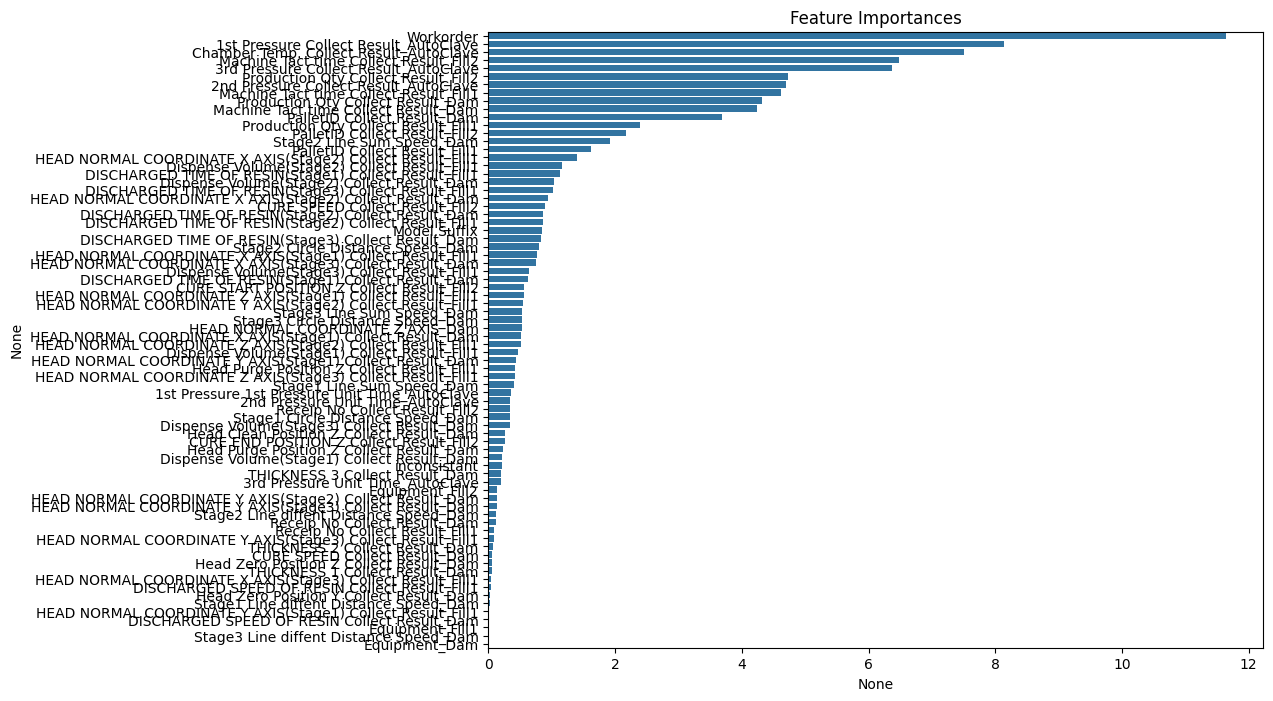

In [355]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [356]:
pred = cat_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  41  417]
 [  58 7586]]

정확도: 0.9414
정밀도: 0.4141
재현율: 0.0895
F1: 0.1472


In [357]:
# Precision - Recall
y_pred_proba = cat_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  97  361]
 [ 449 7195]]

정확도: 0.9000
정밀도: 0.1777
재현율: 0.2118
F1: 0.1932


In [358]:
proba1 = y_pred_proba

### LGBM

In [359]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Workorder', 'Model.Suffix']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'float'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    lgbm_train[column] = lgbm_train[column].astype(dtype)
    lgbm_test[column] = lgbm_test[column].astype(dtype)
    
dtype = 'category'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    lgbm_train[column] = lgbm_train[column].astype(dtype)
    lgbm_test[column] = lgbm_test[column].astype(dtype)
    


In [360]:
X = lgbm_train.drop(columns=['target'])
y = lgbm_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    lgbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
        "max_depth": trial.suggest_int('max_depth', 3, 63),
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
        "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
        "subsample": trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
        "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    }

    model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

    # 범주형 피처 적용
    model.fit(X_train, y_train, categorical_feature=cat_features_indices)

    # 검증 데이터에서 예측 수행
    y_pred = model.predict(X_valid)

    # F1 점수 계산
    f1 = f1_score(y_valid, y_pred)

    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 12:02:35,339] A new study created in memory with name: no-name-2af505b0-f14f-4734-9c6d-91f6b67b155c
[I 2024-08-18 12:02:42,336] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1401, 'max_depth': 58, 'learning_rate': 0.0001224057581391583, 'reg_alpha': 1.4445152903240122, 'reg_lambda': 0.0030676392574149423, 'min_child_weight': 0.659409920397632, 'min_child_samples': 24, 'subsample': 0.6700711873142577, 'subsample_freq': 3, 'colsample_bytree': 0.29779327989607857, 'num_leaves': 64}. Best is trial 0 with value: 0.0.
[I 2024-08-18 12:02:45,348] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 632, 'max_depth': 37, 'learning_rate': 0.00011628671711077811, 'reg_alpha': 0.0315901314664526, 'reg_lambda': 0.008657239156600896, 'min_child_weight': 2.1638298978161217, 'min_child_samples': 18, 'subsample': 0.7945019259289663, 'subsample_freq': 4, 'colsample_bytree': 0.667203190224112, 'num_leaves': 39}. Best is trial 0 with value: 0.0.
[I 2024-08-1

[I 2024-08-18 12:03:58,966] Trial 18 finished with value: 0.13414634146341464 and parameters: {'n_estimators': 1030, 'max_depth': 37, 'learning_rate': 0.009310260439731063, 'reg_alpha': 0.04347923243919726, 'reg_lambda': 0.012153180002308162, 'min_child_weight': 2.784890603191166, 'min_child_samples': 5, 'subsample': 0.9952556930457115, 'subsample_freq': 5, 'colsample_bytree': 0.21757239910228526, 'num_leaves': 58}. Best is trial 18 with value: 0.13414634146341464.
[I 2024-08-18 12:04:04,504] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 1031, 'max_depth': 52, 'learning_rate': 0.0007191570361919327, 'reg_alpha': 0.050829941104859416, 'reg_lambda': 0.02343659989838034, 'min_child_weight': 2.736135236292741, 'min_child_samples': 31, 'subsample': 0.9785659573424639, 'subsample_freq': 4, 'colsample_bytree': 0.22880270322691582, 'num_leaves': 55}. Best is trial 18 with value: 0.13414634146341464.
[I 2024-08-18 12:04:11,466] Trial 20 finished with value: 0.12295081967213

[I 2024-08-18 12:05:54,112] Trial 36 finished with value: 0.11836734693877551 and parameters: {'n_estimators': 832, 'max_depth': 7, 'learning_rate': 0.009620894794839595, 'reg_alpha': 0.07465536695233936, 'reg_lambda': 0.030924837178444107, 'min_child_weight': 2.200031395194557, 'min_child_samples': 20, 'subsample': 0.6313890685232209, 'subsample_freq': 0, 'colsample_bytree': 0.4772325785261474, 'num_leaves': 52}. Best is trial 18 with value: 0.13414634146341464.
[I 2024-08-18 12:05:59,779] Trial 37 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 1151, 'max_depth': 41, 'learning_rate': 0.0036230890648932305, 'reg_alpha': 0.03515873918940852, 'reg_lambda': 0.005378132444358566, 'min_child_weight': 2.927691119577337, 'min_child_samples': 37, 'subsample': 0.8076789563305886, 'subsample_freq': 1, 'colsample_bytree': 0.38681669959721765, 'num_leaves': 44}. Best is trial 18 with value: 0.13414634146341464.
[I 2024-08-18 12:06:04,065] Trial 38 finished with value: 0.

Best trial:
  Value: 0.13414634146341464
  Params: 
    n_estimators: 1030
    max_depth: 37
    learning_rate: 0.009310260439731063
    reg_alpha: 0.04347923243919726
    reg_lambda: 0.012153180002308162
    min_child_weight: 2.784890603191166
    min_child_samples: 5
    subsample: 0.9952556930457115
    subsample_freq: 5
    colsample_bytree: 0.21757239910228526
    num_leaves: 58


In [361]:
lgbm_best_params = study.best_trial.params
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train, y_train, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.21757239910228526,
               learning_rate=0.009310260439731063, max_depth=37,
               min_child_samples=5, min_child_weight=2.784890603191166,
               n_estimators=1030, num_leaves=58, random_state=42,
               reg_alpha=0.04347923243919726, reg_lambda=0.012153180002308162,
               subsample=0.9952556930457115, subsample_freq=5)

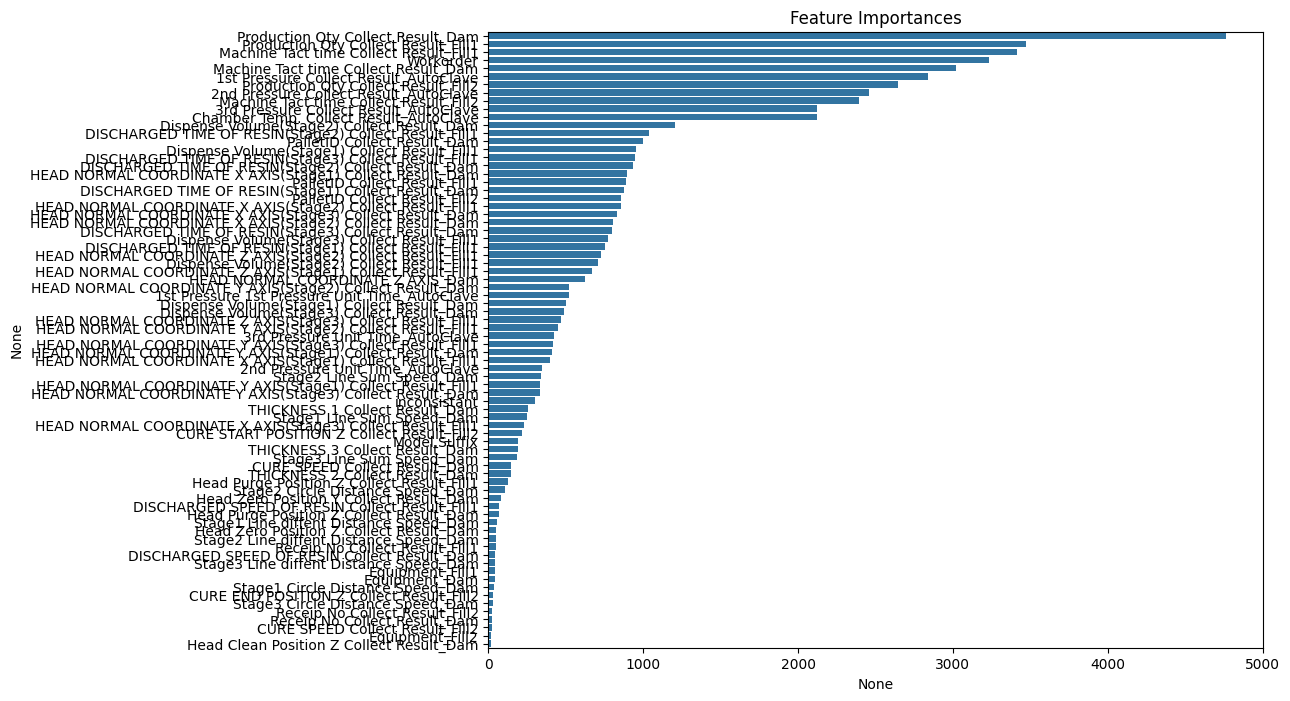

In [362]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [363]:
pred = lgbm_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  33  425]
 [   1 7643]]

정확도: 0.9474
정밀도: 0.9706
재현율: 0.0721
F1: 0.1341


In [364]:
# Precision - Recall
y_pred_proba = lgbm_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
lgbm_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= lgbm_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  94  364]
 [ 248 7396]]

정확도: 0.9245
정밀도: 0.2749
재현율: 0.2052
F1: 0.2350


In [365]:
proba2 = y_pred_proba

# XGB

In [366]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Workorder', 'Model.Suffix']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'float'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    xgb_train[column] = xgb_train[column].astype(dtype)
    xgb_test[column] = xgb_test[column].astype(dtype)

In [367]:
X = xgb_train.drop(columns=['target'])
y = xgb_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

cat_features_indices = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder'] + columns_to

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    model = xgb.XGBClassifier(eval_metric='logloss', **params)
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
    
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds)
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 12:07:28,712] A new study created in memory with name: no-name-ed8a2c2f-769c-408b-94c9-926ed72408ba
[I 2024-08-18 12:07:31,334] Trial 0 finished with value: 0.11498973305954825 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.29709453673633135, 'subsample': 0.7343001562708023, 'colsample_bytree': 0.8426664576613803, 'gamma': 3.1286637001224222, 'lambda': 6.782999067748387, 'alpha': 0.26776913479545494}. Best is trial 0 with value: 0.11498973305954825.
[I 2024-08-18 12:07:35,971] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 947, 'max_depth': 8, 'learning_rate': 0.08064708594721905, 'subsample': 0.9488834978213814, 'colsample_bytree': 0.5288633744675291, 'gamma': 4.018029065392504, 'lambda': 0.007803182655326638, 'alpha': 0.8995440047376807}. Best is trial 0 with value: 0.11498973305954825.
[I 2024-08-18 12:07:38,893] Trial 2 finished with value: 0.10743801652892562 and parameters: {'n_estimators': 578, 'max_depth

[I 2024-08-18 12:08:56,895] Trial 22 finished with value: 0.15183867141162516 and parameters: {'n_estimators': 681, 'max_depth': 8, 'learning_rate': 0.8979273691454853, 'subsample': 0.5470561083140223, 'colsample_bytree': 0.6621320625405356, 'gamma': 1.5204660781797728, 'lambda': 0.38658007436104747, 'alpha': 0.04672978915513148}. Best is trial 13 with value: 0.18575851393188855.
[I 2024-08-18 12:09:01,967] Trial 23 finished with value: 0.17179902755267423 and parameters: {'n_estimators': 832, 'max_depth': 7, 'learning_rate': 0.453477217052666, 'subsample': 0.6236342967349968, 'colsample_bytree': 0.7256731794703277, 'gamma': 0.7260723821039095, 'lambda': 1.236516330517835, 'alpha': 0.002562498348315111}. Best is trial 13 with value: 0.18575851393188855.
[I 2024-08-18 12:09:07,589] Trial 24 finished with value: 0.15307820299500832 and parameters: {'n_estimators': 866, 'max_depth': 5, 'learning_rate': 0.3941471332416349, 'subsample': 0.6130310273602461, 'colsample_bytree': 0.789816152836

[I 2024-08-18 12:10:33,720] Trial 44 finished with value: 0.17894736842105263 and parameters: {'n_estimators': 796, 'max_depth': 8, 'learning_rate': 0.6507364880390532, 'subsample': 0.5692488318390412, 'colsample_bytree': 0.6363753373099719, 'gamma': 1.3631421959136183, 'lambda': 0.16936705453062406, 'alpha': 0.004912559555551249}. Best is trial 13 with value: 0.18575851393188855.
[I 2024-08-18 12:10:39,255] Trial 45 finished with value: 0.16306156405990016 and parameters: {'n_estimators': 883, 'max_depth': 8, 'learning_rate': 0.2551003050321001, 'subsample': 0.5641146457049803, 'colsample_bytree': 0.5872834687952881, 'gamma': 0.4872728215198616, 'lambda': 0.15128933176426707, 'alpha': 0.0014319484318284486}. Best is trial 13 with value: 0.18575851393188855.
[I 2024-08-18 12:10:43,857] Trial 46 finished with value: 0.15807560137457044 and parameters: {'n_estimators': 819, 'max_depth': 9, 'learning_rate': 0.34789699008916236, 'subsample': 0.5901910999801874, 'colsample_bytree': 0.613943

Best trial:
  Value: 0.18575851393188855
  Params: 
    n_estimators: 736
    max_depth: 7
    learning_rate: 0.9648613820512888
    subsample: 0.6250834959143424
    colsample_bytree: 0.730279251707214
    gamma: 1.231665995637223
    lambda: 0.6760593653850686
    alpha: 6.123548593010552


In [500]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params = study.best_trial.params
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train, y_train)

ValueError: No trials are completed yet.

In [501]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [502]:
pred = xgb_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  60  398]
 [ 128 7516]]

정확도: 0.9351
정밀도: 0.3191
재현율: 0.1310
F1: 0.1858


In [503]:
# Precision - Recall

y_pred_proba = xgb_best_model.predict_proba(X_valid)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  85  373]
 [ 254 7390]]

정확도: 0.9226
정밀도: 0.2507
재현율: 0.1856
F1: 0.2133


In [372]:
proba3 = y_pred_proba

### TabNet

In [373]:
columns_to_convert = ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2', 'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1', 'PalletID Collect Result_Fill2', 'Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2', 'Model.Suffix', 'Workorder']  # 변환할 컬럼명 리스트
columns_to = ['Head Zero Position Y Collect Result_Dam',
                'Head Zero Position Z Collect Result_Dam',
                'Head Clean Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Dam',
                'Head Purge Position Z Collect Result_Fill1',
                'CURE START POSITION Z Collect Result_Fill2',
                'CURE END POSITION Z Collect Result_Fill2',
                'CURE SPEED Collect Result_Fill2',
                'Stage1 Circle Distance Speed_Dam',
                'Stage2 Circle Distance Speed_Dam',
                'Stage3 Circle Distance Speed_Dam',
                'Stage1 Line diffent Distance Speed_Dam',
                'Stage1 Line Sum Speed_Dam',
                'Stage2 Line diffent Distance Speed_Dam',
                'Stage2 Line Sum Speed_Dam',
                'Stage3 Line diffent Distance Speed_Dam',
                'Stage3 Line Sum Speed_Dam'
             ]

dtype = 'float'  # 원하는 데이터 타입
for column in columns_to_convert + columns_to:
    tab_train[column] = tab_train[column].astype(dtype)
    tab_test[column] = tab_test[column].astype(dtype)

In [374]:
def preprocess_data():
    X = tab_train.drop(columns=['target'])
    y = tab_train['target'].apply(lambda x: True if x == 'AbNormal' else False)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, X_val, y_train, y_val
    

def objective(trial):
    X_train, X_val, y_train, y_val = preprocess_data()
    
    n_d = trial.suggest_int('n_d', 8, 64)  # Depth of decision predictions
    n_a = trial.suggest_int('n_a', 8, 64)  # Attention embedding size
    n_steps = trial.suggest_int('n_steps', 1, 10)  # Number of steps
    gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
    n_independent = trial.suggest_int('n_independent', 1, 4)  # Number of independent layers
    n_shared = trial.suggest_int('n_shared', 1, 4)  # Number of shared layers
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])  # Batch size
    mask_type = trial.suggest_categorical('mask_type', ['sparsemax', 'entmax'])

    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        n_independent=n_independent,
        n_shared=n_shared,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        scheduler_params=dict(step_size=10, gamma=0.9),
        verbose=0
    )

    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_name=['validation'],
        eval_metric=['balanced_accuracy'],
        max_epochs=50,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # 예측 및 F1 스코어 계산
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='macro')

    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 12:10:57,826] A new study created in memory with name: no-name-2d746265-34bf-4944-b86a-6b55f5bec9b8
/tmp/ipykernel_58/276607018.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
/tmp/ipykernel_58/276607018.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate



Early stopping occurred at epoch 31 with best_epoch = 21 and best_validation_balanced_accuracy = 0.53068


/home/elicer/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-18 12:14:37,803] Trial 0 finished with value: 0.5436305979749325 and parameters: {'n_d': 35, 'n_a': 61, 'n_steps': 6, 'gamma': 1.391865486749431, 'n_independent': 4, 'n_shared': 2, 'lr': 0.007327010649841759, 'batch_size': 256, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.5436305979749325.
/tmp/ipykernel_58/276607018.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
/tmp/ipykernel_58/276607018.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release


Early stopping occurred at epoch 29 with best_epoch = 19 and best_validation_balanced_accuracy = 0.52511


/home/elicer/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-18 12:15:26,870] Trial 1 finished with value: 0.5339838098853553 and parameters: {'n_d': 15, 'n_a': 57, 'n_steps': 3, 'gamma': 1.2307883759945872, 'n_independent': 1, 'n_shared': 2, 'lr': 0.0007542759740132238, 'batch_size': 512, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.5436305979749325.
/tmp/ipykernel_58/276607018.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
/tmp/ipykernel_58/276607018.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea


Early stopping occurred at epoch 10 with best_epoch = 0 and best_validation_balanced_accuracy = 0.51057


/home/elicer/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-18 12:16:53,864] Trial 2 finished with value: 0.5092601983322065 and parameters: {'n_d': 54, 'n_a': 25, 'n_steps': 8, 'gamma': 1.3035668919640844, 'n_independent': 4, 'n_shared': 3, 'lr': 0.009641455090569837, 'batch_size': 512, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.5436305979749325.
/tmp/ipykernel_58/276607018.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
/tmp/ipykernel_58/276607018.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel


Early stopping occurred at epoch 22 with best_epoch = 12 and best_validation_balanced_accuracy = 0.52723


/home/elicer/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-18 12:20:37,899] Trial 3 finished with value: 0.5378488213151642 and parameters: {'n_d': 15, 'n_a': 28, 'n_steps': 10, 'gamma': 1.077417956127198, 'n_independent': 4, 'n_shared': 2, 'lr': 0.003701778157371428, 'batch_size': 256, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.5436305979749325.
/tmp/ipykernel_58/276607018.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1.0, 2.0)  # Relaxation parameter for attention
/tmp/ipykernel_58/276607018.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

KeyboardInterrupt: 

In [375]:
tab_best_params = study.best_trial.params

# cat_idxs 및 cat_dims는 데이터와 특성에 맞게 설정되어야 함
X_train, X_val, y_train, y_val, cat_idxs, cat_dims = preprocess_data()

# TabNet 모델 정의
best_model = TabNetClassifier(
    n_d=tab_best_params['n_d'],
    n_a=tab_best_params['n_a'],
    n_steps=tab_best_params['n_steps'],
    gamma=tab_best_params['gamma'],
    n_independent=tab_best_params['n_independent'],
    n_shared=tab_best_params['n_shared'],
    mask_type=tab_best_params['mask_type'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=tab_best_params['lr']),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.9),
    verbose=0
)
    
# 모델 학습
best_model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['validation'],
    eval_metric=['balanced_accuracy'],
    max_epochs=50,
    batch_size=tab_best_params['batch_size'],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


Early stopping occurred at epoch 15 with best_epoch = 5 and best_validation_balanced_accuracy = 0.52402


/home/elicer/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [376]:
y_pred = best_model.predict(X_val)
get_clf_eval(y_val, y_pred)

오차행렬:
 [[  22  436]
 [   0 7644]]

정확도: 0.9462
정밀도: 1.0000
재현율: 0.0480
F1: 0.0917


In [377]:
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * recall * precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= best_threshold).astype(int)
get_clf_eval(y_val, y_pred_custom_threshold)

오차행렬:
 [[  72  386]
 [ 439 7205]]

정확도: 0.8982
정밀도: 0.1409
재현율: 0.1572
F1: 0.1486


In [378]:
proba4 = y_pred_proba

### Saint

In [381]:
def preprocess_data():
    X = saint_train.drop(columns=['target'])
    y = saint_train['target'].apply(lambda x: True if x == 'AbNormal' else False)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, X_val, y_train, y_val

def objective(trial):
    X_train, X_valid, y_train, y_valid = preprocess_data()
    
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_heads = trial.suggest_int('num_heads', 2, 8)
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model = SaintClassifier(
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        dropout=dropout
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    
    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name=['validation'],
        eval_metric=['f1'],
        max_epochs=50,
        batch_size=batch_size,
        optimizer=optimizer,
        scheduler=scheduler,
        early_stopping_rounds=10
    )
    
    # Evaluate model
    y_pred = model.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='macro')
    
    return f1  # Optuna minimizes the objective, so return 1 - F1 score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Number of trials
    
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 12:24:24,158] A new study created in memory with name: no-name-3be75c59-dadc-4799-8454-b086a6cdb6f5
/tmp/ipykernel_58/2782069981.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[W 2024-08-18 12:24:24,613] Trial 0 failed with parameters: {'num_layers': 4, 'num_heads': 6, 'hidden_dim': 125, 'dropout': 0.4490378734029751, 'learning_rate': 0.0003948044722750849, 'batch_size': 64} because of the following error: NameError("name 'SaintClassifier' is not defined").
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_58/2782069981.py", line 23, in objective
    model = SaintClassifier(
NameError: name 

NameError: name 'SaintClassifier' is not defined

### LSTM

In [ ]:
np.random.seed(0)

In [ ]:
dtype = 'float'  # 원하는 데이터 타입
for column in lstm_train.drop(columns='target').columns:
    lstm_train[column] = lstm_train[column].astype(dtype)
    lstm_test[column] = lstm_test[column].astype(dtype)

In [ ]:
dam_train = lstm_train.filter(regex='_Dam')
fill_train = lstm_train.filter(regex='_Fill')
autoclave_train = lstm_train.filter(regex='AutoClave')
target_train = lstm_train['target'].apply(lambda x: True if x == 'AbNormal' else False)

dam_test = lstm_test.filter(regex='_Dam')
fill_test = lstm_test.filter(regex='_Fill')
autoclave_test = lstm_test.filter(regex='AutoClave')

In [ ]:
def create_sequences(dam_data, fill_data, autoclave_data, target_data, seq_length):
    """
    데이터와 목표 변수를 시퀀스 형식으로 변환하는 함수

    :param dam_data: Dam 관련 시계열 데이터
    :param fill_data: Fill 관련 시계열 데이터
    :param autoclave_data: AutoClave 관련 시계열 데이터
    :param target_data: 목표 변수
    :param seq_length: 시퀀스 길이
    :return: X1 (Dam 시퀀스), X2 (Fill 시퀀스), X3 (AutoClave 시퀀스), y (목표 변수)
    """
    X1, X2, X3, y = [], [], [], []
    for i in range(len(target_data) - seq_length):
        # 각 시퀀스 데이터 생성
        X1.append(dam_data[i:i + seq_length])
        X2.append(fill_data[i:i + seq_length])
        X3.append(autoclave_data[i:i + seq_length])
        y.append(target_data[i + seq_length])  # 목표 변수는 target_data
    return np.array(X1), np.array(X2), np.array(X3), np.array(y)

In [ ]:
import tensorflow as tf

seq_length = 10
X1, X2, X3, y = create_sequences(dam_train.values, fill_train.values, autoclave_train.values, target_train.values, seq_length)

X1_tf = tf.convert_to_tensor(X1, dtype=tf.float32)
X2_tf = tf.convert_to_tensor(X2, dtype=tf.float32)
X3_tf = tf.convert_to_tensor(X3, dtype=tf.float32)
y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test = train_test_split(X1, X2, X3, y, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from tensorflow.keras.models import Model

num_features_dam = X1.shape[2]
num_features_fill = X2.shape[2]
num_features_autoclave = X3.shape[2]

# 입력 레이어 정의
input_dam = Input(shape=(seq_length, num_features_dam))
input_fill = Input(shape=(seq_length, num_features_fill))
input_autoclave = Input(shape=(seq_length, num_features_autoclave))

# LSTM 레이어 정의
lstm_dam = LSTM(50, return_sequences=True)(input_dam)
lstm_dam = LSTM(50, return_sequences=False)(lstm_dam)

lstm_fill = LSTM(50, return_sequences=True)(input_fill)
lstm_fill = LSTM(50, return_sequences=False)(lstm_fill)

lstm_autoclave = LSTM(50, return_sequences=True)(input_autoclave)
lstm_autoclave = LSTM(50, return_sequences=False)(lstm_autoclave)

# LSTM 출력을 결합
merged = concatenate([lstm_dam, lstm_fill, lstm_autoclave])
output = Dense(1)(merged)

# 모델 정의
model = Model(inputs=[input_dam, input_fill, input_autoclave], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
model.summary()

# 모델 훈련
model.fit([X1_train, X2_train, X3_train], y_train, epochs=20, batch_size=32, verbose=1)

In [ ]:
predictions = model.predict([X1_test, X2_test, X3_test])

In [ ]:
print('예측 결과:', predictions)

In [ ]:
predictions.max()

### Voting 실험

In [385]:
y_1_2 = proba1 + proba2 / 2
y_1_3 = proba1 + proba3 / 2
y_2_3 = proba2 + proba3 / 2
y_1_2_3 = proba1 + proba2 + proba3 / 3

In [386]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_2)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_1 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold_1 = (y_1_2 >= best_threshold_1).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold_1)

오차행렬:
 [[  69  389]
 [ 163 7481]]

정확도: 0.9319
정밀도: 0.2974
재현율: 0.1507
F1: 0.2000


In [388]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_2 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_1_3 >= best_threshold_2).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  92  366]
 [ 279 7365]]

정확도: 0.9204
정밀도: 0.2480
재현율: 0.2009
F1: 0.2220


In [389]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_2_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_2_3 >= best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 126  332]
 [ 524 7120]]

정확도: 0.8943
정밀도: 0.1938
재현율: 0.2751
F1: 0.2274


In [390]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_1_2_3)
f1_scores = 2*recall*precision / (recall + precision)
best_threshold_3 = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_1_2_3 >= best_threshold_3).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[  94  364]
 [ 303 7341]]

정확도: 0.9177
정밀도: 0.2368
재현율: 0.2052
F1: 0.2199


In [522]:
best_f1 = 0
best_f1_t = 0
best_weights = None
best_weights_t = None

# 가중치 조합 테스트
for w1 in range(1, 10):
    for w2 in range(0, 10):
        for w3 in range(0, 10):
            for w4 in range(0, 10):
                # 가중 평균 계산
                final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3 + w4 * proba4) / (w1 + w2 + w3 + w4)
                y_pred = (final_proba > 0.5).astype(int)
            
                # F1 스코어 계산
                f1 = f1_score(y_valid, y_pred, average='macro')
                print(f1)
                
                # Threshold 스코어 계산
                precision, recall, thresholds = precision_recall_curve(y_valid, final_proba)
                f1_scores = 2*recall*precision / (recall + precision)
                best_threshold = thresholds[np.argmax(f1_scores)]
                y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
                f1_t = f1_score(y_valid, y_pred_custom_threshold, average='macro')

                # 최고 성능 저장
                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = (w1, w2, w3, w4)
                
                if f1_t > best_f1_t:
                    best_f1_t = f1_t
                    best_weights_t = (w1, w2, w3, w4)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.5584299891031704
0.549808936924135
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5706945846333878
0.5544145278777868
0.5459006119402224
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5725013871706793
0.5612643298477801
0.5514204874737139
0.5439345836625671
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5695868925434967
0.570315723695993
0.5547769333269077
0.5515856407507217
0.5419605795861991
0.5359902158932616
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5714871740184865
0.5670057042593528
0.5655674159282159
0.549957716865829
0.5515856407507217
0.5419605795861991
0.5399785502491956
0.5319691766302044
0.5319691766302044
0.5319691766302044
0.5697167742162087
0.5688708257029144
0.5680404211078

0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5686650691978783
0.5645456491938083
0.5587274604594361
0.5571797933501416
0.5535166534200984
0.549808936924135
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5702933789939304
0.567058103817756
0.5651061105893873
0.5587274604594361
0.5533479146598622
0.5515856407507217
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5672375046411798
0.5708696772205383
0.5656251358862153
0.5636281304415555
0.5571797933501416
0.5514204874737139
0.5515856407507217
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5659609688221261
0.5697223926321926
0.5698736860647696
0.5627073666219387
0.5638140734000607
0.5552676677739494
0.5514204874737139
0.5515856407507217
0.5459006119402224
0.5459006119402224
0.5679076370805196
0.567053493738887
0.5706769820061922
0.5652528359400729
0.5632580453883888
0.560076342192052
0.5533479146598622
0.5514204874737139
0.5515856407507217
0.54590061194022

0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5592636531461409
0.553685942199196
0.549808936924135
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5573556129956679
0.5573556129956679
0.5517513305436722
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5590843375473357
0.5573556129956679
0.5556128193664829
0.5517513305436722
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5589056078368729
0.5590843375473357
0.5556128193664829
0.5556128193664829
0.549808936924135
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5604365766683648
0.5587274604594361
0.5573556129956679
0.5556128193664829
0.5536859421991

0.5638066866464476
0.5598970978916008
0.5552676677739494
0.5535166534200984
0.5515856407507217
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5697223926321926
0.5663080955713232
0.5645456491938083
0.5602561672807985
0.5535166534200984
0.5515856407507217
0.5515856407507217
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5685960000961267
0.5708696772205383
0.5632585828939265
0.5627073666219387
0.5589056078368729
0.5535166534200984
0.5515856407507217
0.5515856407507217
0.5478587134756685
0.5439345836625671
0.5671254515256049
0.5693446418901635
0.5679051445822286
0.5632585828939265
0.5614028019983915
0.5550959335541422
0.5515856407507217
0.5515856407507217
0.5515856407507217
0.5478587134756685
0.5677261998588932
0.5666871328399148
0.5701024644529373
0.5664947146373248
0.5621619425744486
0.5597184308967749
0.5550959335541422
0.5514204874737139
0.5515856407507217
0.5515856407507217
0.5609813461529347
0.5573556129956679
0.5478587134756685
0.5439345836

0.5535166534200984
0.5515856407507217
0.549808936924135
0.5592636531461409
0.5554399618979893
0.549808936924135
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5592636531461409
0.5592636531461409
0.553685942199196
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5590843375473357
0.5573556129956679
0.5575320091361164
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5571797933501416
0.5571797933501416
0.5573556129956679
0.553685942199196
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5589056078368729
0.5571797933501416
0.5571797933501416
0.5575320091361164
0.5517513305436722
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.54393458366256

0.5663080955713232
0.5623431724764212
0.5561367871148106
0.5549247558260841
0.5535166534200984
0.5515856407507217
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5691088177567135
0.5630770289103331
0.5608619866299568
0.5564822098829942
0.5552676677739494
0.5515856407507217
0.5515856407507217
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5712672104531538
0.5663080955713232
0.5616216809174247
0.5571497663029117
0.5549247558260841
0.5535166534200984
0.5515856407507217
0.5515856407507217
0.5459006119402224
0.5439345836625671
0.5716470696672511
0.5702933789939304
0.5628960430031585
0.5619812862538532
0.5578453361102096
0.5531797225522308
0.5515856407507217
0.5515856407507217
0.5515856407507217
0.5459006119402224
0.5688228473160488
0.5706945846333878
0.5675287368495332
0.5634407082753661
0.5603263207366811
0.5526783928886876
0.5531797225522308
0.5515856407507217
0.5515856407507217
0.5515856407507217
0.569401319608525
0.569939144531591
0.569722392632

0.5570045466867098
0.5554399618979893
0.5535166534200984
0.5535166534200984
0.5517513305436722
0.549808936924135
0.5661220595108273
0.5632585828939265
0.564360024216161
0.5615842340970195
0.5604365766683648
0.5554399618979893
0.5535166534200984
0.5535166534200984
0.5515856407507217
0.5515856407507217
0.5592636531461409
0.5592636531461409
0.5496468766964594
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5590843375473357
0.5592636531461409
0.5573556129956679
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5589056078368729
0.5571797933501416
0.5573556129956679
0.553685942199196
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5570045466867098
0.5571797933501416
0.5571797933501416
0.5575320091361164
0.553685942199196
0.5459006119402224
0.54393458366256

0.5319691766302044
0.5655674159282159
0.5623431724764212
0.5576706096451319
0.5566557583958655
0.5552676677739494
0.549808936924135
0.5459006119402224
0.5459006119402224
0.5439345836625671
0.5419605795861991
0.568919084844268
0.5630770289103331
0.5573228280634929
0.5544145278777868
0.5549247558260841
0.5535166534200984
0.549808936924135
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5697223926321926
0.5643322782390742
0.5603263207366811
0.555622788393489
0.5544145278777868
0.5552676677739494
0.5515856407507217
0.5496468766964594
0.5459006119402224
0.5439345836625671
0.5739313349861017
0.5657517230072704
0.5648828791713261
0.558658360757327
0.5539091881106322
0.5549247558260841
0.5514204874737139
0.5515856407507217
0.5496468766964594
0.5459006119402224
0.5727716412883144
0.5701024644529373
0.5663080955713232
0.561442725246878
0.5573228280634929
0.5545840563322947
0.5531797225522308
0.5514204874737139
0.5515856407507217
0.5496468766964594
0.5686387256154698
0.5724137346085503

0.5554399618979893
0.5535166534200984
0.5535166534200984
0.5517513305436722
0.549808936924135
0.5664947146373248
0.561442725246878
0.5628903377309731
0.5598970978916008
0.5566557583958655
0.5573556129956679
0.5535166534200984
0.5535166534200984
0.5515856407507217
0.5517513305436722
0.568919084844268
0.5648828791713261
0.5619812862538532
0.5612219523598965
0.560076342192052
0.5566557583958655
0.5535166534200984
0.5535166534200984
0.5535166534200984
0.5515856407507217
0.5606175738934093
0.5611641284079615
0.5535166534200984
0.5515856407507217
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5606175738934093
0.5607991625230069
0.5592636531461409
0.5515856407507217
0.549808936924135
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5607991625230069
0.5589056078368729
0.5571797933501416
0.5554399618979893
0.5517513305436722
0.549808936924135
0.5439345836625671
0.5439345836625671

0.5581964771978046
0.5549247558260841
0.5515856407507217
0.5459006119402224
0.5459006119402224
0.5419605795861991
0.5319691766302044
0.5674220733271732
0.5643322782390742
0.5619812862538532
0.5576706096451319
0.5563092205807438
0.5514204874737139
0.5517513305436722
0.5459006119402224
0.5459006119402224
0.5419605795861991
0.5716518886293577
0.5639680616171464
0.5616216809174247
0.5554525450634114
0.5559649061377722
0.5550959335541422
0.5514204874737139
0.549808936924135
0.5459006119402224
0.5459006119402224
0.5706945846333878
0.5691088177567135
0.5628960430031585
0.5571497663029117
0.555622788393489
0.5544145278777868
0.5533479146598622
0.5494853393022473
0.549808936924135
0.5459006119402224
0.5739313349861017
0.5679791576080636
0.5627156218764697
0.561442725246878
0.5552828410960435
0.5542455425369333
0.5547541312047494
0.5514204874737139
0.5494853393022473
0.549808936924135
0.5761406608221573
0.5726068581984953
0.5655674159282159
0.5632585828939265
0.558658360757327
0.5535749671418462

0.5552676677739494
0.5554399618979893
0.5535166534200984
0.5517513305436722
0.5459006119402224
0.5645152384484542
0.5638066866464476
0.561041681716391
0.5561367871148106
0.5564822098829942
0.5549247558260841
0.5554399618979893
0.5535166534200984
0.5515856407507217
0.5517513305436722
0.5663080955713232
0.5630770289103331
0.5621619425744486
0.5574964414079474
0.5564822098829942
0.5566557583958655
0.5554399618979893
0.5535166534200984
0.5535166534200984
0.5515856407507217
0.568919084844268
0.5664947146373248
0.561442725246878
0.5606828636896328
0.5578453361102096
0.5564822098829942
0.5549247558260841
0.5535166534200984
0.5535166534200984
0.5515856407507217
0.5634427889658409
0.5625002547121752
0.5573556129956679
0.5535166534200984
0.5517513305436722
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5640006214543831
0.5606175738934093
0.5607991625230069
0.5573556129956679
0.5515856407507217
0.549808936924135
0.5439345836625671
0.54393458366256

0.549808936924135
0.5478587134756685
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5439345836625671
0.5607991625230069
0.5592636531461409
0.5592636531461409
0.5573556129956679
0.5515856407507217
0.5478587134756685
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5607991625230069
0.5589056078368729
0.5592636531461409
0.5573556129956679
0.5554399618979893
0.5517513305436722
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5607991625230069
0.5589056078368729
0.5571797933501416
0.5573556129956679
0.5554399618979893
0.553685942199196
0.5517513305436722
0.5459006119402224
0.5439345836625671
0.5439345836625671
0.5607991625230069
0.5570045466867098
0.5570045466867098
0.5571797933501416
0.5573556129956679
0.5556128193664829
0.553685942199196
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5566557583958655
0.5570045466867098
0.5570045466867098
0.5571797933501416
0.5571797933501416
0.5556128193664829
0.5556128193664

0.5606828636896328
0.5576706096451319
0.5580206241649122
0.5547541312047494
0.5549247558260841
0.5554399618979893
0.5554399618979893
0.549808936924135
0.5459006119402224
0.5677166473375542
0.5605043095111523
0.5591858593314041
0.5578453361102096
0.5564822098829942
0.5549247558260841
0.5550959335541422
0.5554399618979893
0.5515856407507217
0.549808936924135
0.5692991409373139
0.5632585828939265
0.5606828636896328
0.5593628150309422
0.5561367871148106
0.5545840563322947
0.5549247558260841
0.5554399618979893
0.5535166534200984
0.5515856407507217
0.5657517230072704
0.5645152384484542
0.5638066866464476
0.5588336355289404
0.5557935743288185
0.5563092205807438
0.5547541312047494
0.5552676677739494
0.5535166534200984
0.5515856407507217
0.5687299388406875
0.5663080955713232
0.5628960430031585
0.5621619425744486
0.5574964414079474
0.5559649061377722
0.5545840563322947
0.5549247558260841
0.5552676677739494
0.5535166534200984
0.5618012001482704
0.5632580453883888
0.5607991625230069
0.557355612995

0.5535166534200984
0.5604365766683648
0.5607991625230069
0.5611641284079615
0.5554399618979893
0.5535166534200984
0.5517513305436722
0.5478587134756685
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5606175738934093
0.5607991625230069
0.5611641284079615
0.5573556129956679
0.5535166534200984
0.549808936924135
0.549808936924135
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5606175738934093
0.5607991625230069
0.5607991625230069
0.5592636531461409
0.5554399618979893
0.5515856407507217
0.549808936924135
0.5478587134756685
0.5439345836625671
0.5439345836625671
0.5606175738934093
0.5607991625230069
0.5589056078368729
0.5571797933501416
0.5554399618979893
0.5554399618979893
0.5517513305436722
0.549808936924135
0.5459006119402224
0.5439345836625671
0.5602561672807985
0.5606175738934093
0.5570045466867098
0.5570045466867098
0.5571797933501416
0.5554399618979893
0.5556128193664829
0.5517513305436722
0.5478587134756685
0.5439345836625671
0.5598970978916008
0.55854989188820

0.5459006119402224
0.5657517230072704
0.5634407082753661
0.5588336355289404
0.5576706096451319
0.5561367871148106
0.5566557583958655
0.5549247558260841
0.5552676677739494
0.5515856407507217
0.549808936924135
0.5675287368495332
0.5643322782390742
0.5606828636896328
0.5573228280634929
0.5576706096451319
0.5563092205807438
0.5549247558260841
0.5552676677739494
0.5554399618979893
0.5496468766964594
0.5692991409373139
0.5677166473375542
0.5618012001482704
0.5591858593314041
0.5574964414079474
0.5561367871148106
0.5545840563322947
0.5549247558260841
0.5552676677739494
0.5515856407507217
0.5685413764119334
0.5694900577708506
0.5632585828939265
0.5605043095111523
0.5573228280634929
0.5557935743288185
0.5544145278777868
0.5545840563322947
0.5552676677739494
0.5533479146598622
0.5697223926321926
0.5657517230072704
0.564698770983606
0.5596199534330293
0.5588336355289404
0.5554525450634114
0.5540770970318167
0.5544145278777868
0.5549247558260841
0.5552676677739494
0.559338042649156
0.5616216809174

0.5554399618979893
0.5554399618979893
0.5634427889658409
0.5625002547121752
0.5607991625230069
0.5573556129956679
0.5535166534200984
0.5515856407507217
0.5517513305436722
0.5478587134756685
0.5459006119402224
0.5439345836625671
0.5640006214543831
0.5625002547121752
0.5607991625230069
0.5592636531461409
0.5554399618979893
0.5535166534200984
0.549808936924135
0.549808936924135
0.5459006119402224
0.5439345836625671
0.5638140734000607
0.5604365766683648
0.5607991625230069
0.5607991625230069
0.5573556129956679
0.5535166534200984
0.5517513305436722
0.549808936924135
0.549808936924135
0.5439345836625671
0.5617662521484177
0.5602561672807985
0.5607991625230069
0.5607991625230069
0.5552676677739494
0.5554399618979893
0.5535166534200984
0.5517513305436722
0.549808936924135
0.5459006119402224
0.5598970978916008
0.560076342192052
0.5606175738934093
0.5589056078368729
0.5570045466867098
0.5552676677739494
0.5554399618979893
0.5556128193664829
0.5517513305436722
0.5478587134756685
0.5597184308967749

0.5549247558260841
0.5515856407507217
0.5517513305436722
0.5664134095040336
0.5643322782390742
0.5616216809174247
0.5605043095111523
0.5574964414079474
0.5561367871148106
0.5563092205807438
0.5549247558260841
0.5533479146598622
0.5515856407507217
0.5701024644529373
0.5639680616171464
0.5634407082753661
0.5588336355289404
0.5573228280634929
0.5557935743288185
0.5561367871148106
0.5547541312047494
0.5552676677739494
0.5514204874737139
0.5704848837253931
0.5657517230072704
0.5639680616171464
0.5623431724764212
0.5573228280634929
0.555622788393489
0.5561367871148106
0.5544145278777868
0.5550959335541422
0.5552676677739494
0.5695332287593072
0.5691088177567135
0.5639680616171464
0.5616216809174247
0.5591858593314041
0.5573228280634929
0.5557935743288185
0.5544145278777868
0.5545840563322947
0.5552676677739494
0.5710757529370452
0.5685413764119334
0.5679051445822286
0.561442725246878
0.5619812862538532
0.5573228280634929
0.5554525450634114
0.5542455425369333
0.5544145278777868
0.555095933554

0.5549247558260841
0.5550959335541422
0.5554399618979893
0.5621619425744486
0.5632580453883888
0.5625002547121752
0.5589056078368729
0.5573556129956679
0.5554399618979893
0.5515856407507217
0.5517513305436722
0.5459006119402224
0.5459006119402224
0.5630738961528892
0.5636281304415555
0.5623158573637925
0.5589056078368729
0.5573556129956679
0.5573556129956679
0.5515856407507217
0.549808936924135
0.549808936924135
0.5459006119402224
0.5628903377309731
0.5636281304415555
0.562132060219192
0.5607991625230069
0.5589056078368729
0.5573556129956679
0.5535166534200984
0.5517513305436722
0.549808936924135
0.5478587134756685
0.5628903377309731
0.5617662521484177
0.5602561672807985
0.5607991625230069
0.5570045466867098
0.5552676677739494
0.5554399618979893
0.553685942199196
0.5517513305436722
0.549808936924135
0.5627073666219387
0.5615842340970195
0.5602561672807985
0.5585498918882017
0.5589056078368729
0.5550959335541422
0.5552676677739494
0.5554399618979893
0.553685942199196
0.5517513305436722


0.5634407082753661
0.5584836396698243
0.5576706096451319
0.5581964771978046
0.5544145278777868
0.5549247558260841
0.5515856407507217
0.5651378012333068
0.5669684924679977
0.5627156218764697
0.5616216809174247
0.5584836396698243
0.5574964414079474
0.5561367871148106
0.5563092205807438
0.5549247558260841
0.5514204874737139
0.5695332287593072
0.5665978690984736
0.5627156218764697
0.5616216809174247
0.5621619425744486
0.5574964414079474
0.5559649061377722
0.5561367871148106
0.5564822098829942
0.5531797225522308
0.5716518886293577
0.5667828956751826
0.5639680616171464
0.5628960430031585
0.5603263207366811
0.5554525450634114
0.555622788393489
0.5559649061377722
0.5563092205807438
0.5550959335541422
0.5693446418901635
0.568919084844268
0.5637867986769864
0.5641498870540583
0.5618012001482704
0.5573228280634929
0.5554525450634114
0.5557935743288185
0.5544145278777868
0.5547541312047494
0.5706945846333878
0.5699121367686538
0.5673414097597563
0.5641498870540583
0.561442725246878
0.5584836396698

0.5605043095111523
0.5591858593314041
0.5574964414079474
0.5578453361102096
0.5563092205807438
0.5545840563322947
0.5549247558260841
0.5550959335541422
0.5605562860707128
0.5621619425744486
0.5630738961528892
0.5604365766683648
0.5589056078368729
0.5573556129956679
0.5554399618979893
0.5515856407507217
0.549808936924135
0.5478587134756685
0.560909206834991
0.5630738961528892
0.5632580453883888
0.5604365766683648
0.5607991625230069
0.5573556129956679
0.5573556129956679
0.5515856407507217
0.549808936924135
0.5478587134756685
0.561442725246878
0.5628903377309731
0.5634427889658409
0.5619488596729919
0.5589056078368729
0.5589056078368729
0.5554399618979893
0.5535166534200984
0.5517513305436722
0.549808936924135
0.5618012001482704
0.5628903377309731
0.5634427889658409
0.562132060219192
0.5587274604594361
0.5570045466867098
0.5571797933501416
0.5535166534200984
0.553685942199196
0.5517513305436722
0.5619812862538532
0.5627073666219387
0.5617662521484177
0.5602561672807985
0.5583728986245542


0.5606175738934093
0.5607991625230069
0.5589056078368729
0.5571797933501416
0.5554399618979893
0.5554399618979893
0.553685942199196
0.5517513305436722
0.5598970978916008
0.560076342192052
0.5604365766683648
0.5589056078368729
0.5589056078368729
0.5570045466867098
0.5552676677739494
0.5552676677739494
0.5554399618979893
0.553685942199196
0.5597184308967749
0.560076342192052
0.5583728986245542
0.5587274604594361
0.5570045466867098
0.5570045466867098
0.5571797933501416
0.5552676677739494
0.5552676677739494
0.5556128193664829
0.5615842340970195
0.5580206241649122
0.5583728986245542
0.5583728986245542
0.5570045466867098
0.5570045466867098
0.5570045466867098
0.5552676677739494
0.5552676677739494
0.5554399618979893
0.5597184308967749
0.5578453361102096
0.5580206241649122
0.5583728986245542
0.5566557583958655
0.5570045466867098
0.5570045466867098
0.5552676677739494
0.5552676677739494
0.5554399618979893
0.5593628150309422
0.5597184308967749
0.5578453361102096
0.5583728986245542
0.55648220988299

In [520]:
final_proba

array([nan, nan, nan, ..., nan, nan, nan])

In [524]:
best_weights_t

(1, 9, 1, 0)

In [462]:
y_best = (best_weights[0] * proba1 + best_weights[1] * proba2 + best_weights[2] * proba3 + best_weights[3] * proba4) / (best_weights[0] + best_weights[1] + best_weights[2] + best_weights[3])

In [536]:
y_best = (best_weights_t[0] * proba1 + best_weights_t[1] * proba2 + best_weights_t[2] * proba3 + best_weights_t[3] * proba4) / (best_weights_t[0] + best_weights_t[1] + best_weights_t[2] + best_weights_t[3])

In [537]:
y_best

array([0.05190611, 0.0395253 , 0.02009806, ..., 0.21199872, 0.08910628,
       0.00879645])

In [538]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 100  358]
 [ 266 7378]]

정확도: 0.9230
정밀도: 0.2732
재현율: 0.2183
F1: 0.2427


In [539]:
weights_best_threshold

0.16478862000239425

### 민감성 예측

In [397]:
y_pred_custom_threshold_1 = (proba1 >= cat_best_threshold).astype(int)
y_pred_custom_threshold_2 = (proba2 >= lgbm_best_threshold).astype(int)
y_pred_custom_threshold_3 = (proba3 >= best_threshold).astype(int)

result1 = np.logical_or(y_pred_custom_threshold_1, y_pred_custom_threshold_2)
result2 = np.logical_or(y_pred_custom_threshold_1, y_pred_custom_threshold_3)
result3 = np.logical_or(y_pred_custom_threshold_2, y_pred_custom_threshold_3)
result4 = np.logical_or(y_pred_custom_threshold_2, y_pred_custom_threshold_3)
result4 = np.logical_or(result4, y_pred_custom_threshold_1)
result5 = np.logical_or()

get_clf_eval(y_valid, result1)

오차행렬:
 [[ 128  330]
 [ 587 7057]]

정확도: 0.8868
정밀도: 0.1790
재현율: 0.2795
F1: 0.2182


In [398]:
get_clf_eval(y_valid, result2)

오차행렬:
 [[  97  361]
 [ 449 7195]]

정확도: 0.9000
정밀도: 0.1777
재현율: 0.2118
F1: 0.1932


In [399]:
get_clf_eval(y_valid, result3)

오차행렬:
 [[  94  364]
 [ 248 7396]]

정확도: 0.9245
정밀도: 0.2749
재현율: 0.2052
F1: 0.2350


In [400]:
get_clf_eval(y_valid, result4)

오차행렬:
 [[ 128  330]
 [ 587 7057]]

정확도: 0.8868
정밀도: 0.1790
재현율: 0.2795
F1: 0.2182


# 학습 후 예측 및 제출용 데이터 생성

In [471]:
set_id = pd.read_csv('test_df.csv')
cat_test = pd.concat([cat_test, set_id['Set ID']], axis = 1)
xgb_test = pd.concat([xgb_test, set_id['Set ID']], axis = 1)
lgbm_test = pd.concat([lgbm_test, set_id['Set ID']], axis = 1)

### Catboost

In [472]:
cat_test_pool = Pool(data=cat_test.drop(columns='Set ID'), cat_features=cat_features_indices)

In [473]:
cat_pred = cat_best_model.predict(cat_test.drop(columns='Set ID'))

In [474]:
sum(cat_pred)

208

In [475]:
cat_pred_proba = cat_best_model.predict_proba(cat_test.drop(columns='Set ID'))[:, 1]

In [476]:
y_pred_cat = (cat_pred_proba >= cat_best_threshold).astype(int)

In [477]:
sum(y_pred_cat)

1067

### LGBM

In [478]:
lgbm_pred = lgbm_best_model.predict(lgbm_test.drop(columns='Set ID'))

In [479]:
sum(lgbm_pred)

72

In [480]:
lgbm_pred_proba = lgbm_best_model.predict_proba(lgbm_test.drop(columns='Set ID'))[:, 1]

In [481]:
y_pred_lgbm = (lgbm_pred_proba >= lgbm_best_threshold).astype(int)

In [482]:
sum(y_pred_lgbm)

723

### XGB

In [483]:
xgb_pred = xgb_best_model.predict(xgb_test.drop(columns='Set ID'))

In [484]:
sum(xgb_pred)

520

In [504]:
xgb_pred_proba = xgb_best_model.predict_proba(xgb_test.drop(columns='Set ID'))[:, 1]

In [505]:
y_pred_xgb = (xgb_pred_proba >= best_threshold).astype(int)

In [506]:
sum(y_pred_lgbm)

723

### Voting

In [561]:
y_result

array([0.65593831, 0.11396534, 1.08872324, ..., 0.43242133, 0.8262208 ,
       0.13698829])

In [507]:
y_pead_1_2 = cat_pred_proba + lgbm_pred_proba / 2
y_pred_1_3 = cat_pred_proba + xgb_pred_proba / 2
y_pred_2_3 = lgbm_pred_proba + xgb_pred_proba / 2
y_pred_1_2_3 = cat_pred_proba + lgbm_pred_proba + xgb_pred_proba / 3

In [ ]:
y_result = (cat_pred_proba * 1 + lgbm_pred_proba * 9 + xgb_pred_proba * 1 / 11

In [559]:
y_pred_custom_threshold = (y_result >= weights_best_threshold).astype(int)

In [560]:
sum(y_pred_custom_threshold)

1664

In [495]:
result1 = np.logical_or(y_pred_xgb, y_pred_lgbm)

In [497]:
sum(result1)

723

### 데이터 결정 및 결합

In [511]:
result = y_pred_custom_threshold

In [512]:
y_pred = np.where(result == 0, "Normal", "AbNormal")

In [513]:
y_pred

array(['Normal', 'Normal', 'AbNormal', ..., 'Normal', 'Normal', 'Normal'],
      dtype='<U8')

In [514]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)